In [1]:
import pandas as pd
import numpy as np
from utils.utils import confidence_ellipse , save_fna
from zipfile import ZipFile

#Qiime
import qiime2 as q2
from qiime2.plugins.diversity.actions import alpha
from qiime2.plugins.diversity.actions import beta
from qiime2.plugins.feature_table.actions import rarefy
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 
from qiime2.plugins.qurro.actions import differential_plot
from qiime2.plugins.taxa.actions import collapse 
from biom import Table, load_table

#Stats
from scipy.stats import sem
from skbio import OrdinationResults
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from scipy import stats
from skbio.stats.distance import mantel

#Plotting
import plotnine as pn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline

# Import data

16S

In [93]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
#Import biom
bac_bt = load_table(root_dir + "intermediate_data/20200611_filtered_16S_table.biom")
qza =  q2.Artifact.import_data('FeatureTable[Frequency]', bac_bt)

#Import metadata
bac_md = pd.read_csv(root_dir + "intermediate_data/20200611_filtered_16S_metadata.tsv", sep='\t', index_col=0)


#Import taxonomy
tax_qza =  q2.Artifact.load(root_dir + "intermediate_data/stody_seq_classification.qza")
tax_md_qza = q2.Metadata(pd.DataFrame(tax_qza.view(pd.Series)))
tax_df = tax_qza.view(pd.DataFrame)

#Collapse to genus
genus_qza = collapse(table=qza, taxonomy=tax_qza, level=6).collapsed_table
genus_bt = genus_qza.view(Table)


Metabolomics

In [94]:
#Data
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
bt = load_table(root_dir + "intermediate_data/20200611_filtered_metabolmics_table.biom")
#Make into cpm
bt.transform(lambda x,y,z: x*1000000)

#Metadata
met_md=pd.read_csv(root_dir + "intermediate_data/20200611_filtered_metabolomics_metadata.tsv", sep='\t', index_col=0)
met_md.index.name="sample_name"
doty_samples = set( met_md.query('qiita_study_id==11712').index )
swell_samples = set( met_md.query('qiita_study_id==11713').index )


#Spit by chorot
doty_bt = bt.filter(doty_samples, inplace=False)
swell_bt = bt.filter(swell_samples, inplace=False)

#Convert to qiime2
doty_qza = q2.Artifact.import_data('FeatureTable[Frequency]', doty_bt)
swell_qza = q2.Artifact.import_data('FeatureTable[Frequency]', swell_bt)



#Get feature metadata
met_md = pd.concat([swell_bt.metadata_to_dataframe(axis="observation"),doty_bt.metadata_to_dataframe(axis="observation")])
met_md = met_md.loc[~met_md.index.duplicated(keep='first')]

met_md["Bile_acid_full_class"] = met_md.apply(axis=1, func=lambda row: row.Bile_Acid_Class + row.Bile_Acid_Subclass)

# Filter

Only using Doty  
Filter to only samples with both data

In [95]:
bac_samples = set(bac_md.index)

samples_keep = doty_samples & bac_samples

bac_bt_filt = genus_bt.filter(samples_keep, inplace=False)
met_bt_filt = doty_bt.filter(samples_keep, inplace=False)

bac_qza_filt = q2.Artifact.import_data('FeatureTable[Frequency]', bac_bt_filt)
met_qza_filt = q2.Artifact.import_data('FeatureTable[Frequency]', met_bt_filt)

md = bac_md.query('index in @samples_keep')
md_q2 = q2.Metadata(md)

Get stool samples  
Only LPI-Vaginal abx-

In [371]:
md_stool = md.query('sample_type=="Stool"').copy()
stool_samples = set( md_stool.index )


#Get stool samples
bac_bt_stool = bac_bt_filt.filter(stool_samples, inplace=False)
met_bt_stool = met_bt_filt.filter(stool_samples, inplace=False)

#Filter to only bile acids
bile_acid_list = set(met_md.query('Bile_Acid_Class != "nan"').index) & set( met_bt_stool.ids("observation") )
secondary_bile_acid_list = set(met_md.query('Bile_Acid_Class == "Secondary"').index) & set( met_bt_stool.ids("observation") )
met_bt_stool_ba = met_bt_stool.filter(bile_acid_list, inplace=False, axis="observation")
met_bt_stool_sba = met_bt_stool.filter(secondary_bile_acid_list, inplace=False, axis="observation")

#Filter to only confirmed secondary bile acids
conf_bile_acid_list = set(met_md_ss.query('Bile_Acid_Class=="Secondary" & StandardMatch not in ["No","nan"]').index)
met_bt_stool_csba = met_bt_stool.filter(conf_bile_acid_list, inplace=False, axis="observation")

bin_f = lambda id_, x: x['StandardMatch']
met_bt_stool_csba_collapse = met_bt_stool_csba.collapse(bin_f, norm=False, axis="observation")

#Convert to qiime2
bac_qza_stool = q2.Artifact.import_data('FeatureTable[Frequency]', bac_bt_stool)
met_qza_stool = q2.Artifact.import_data('FeatureTable[Frequency]', met_bt_stool)
met_qza_stool_ba = q2.Artifact.import_data('FeatureTable[Frequency]', met_bt_stool_ba)
met_qza_stool_sba = q2.Artifact.import_data('FeatureTable[Frequency]', met_bt_stool_sba)
met_qza_stool_csba = q2.Artifact.import_data('FeatureTable[Frequency]', met_bt_stool_csba_collapse)


md_stool_q2 = q2.Metadata(md_stool)




# Mantel test
Mantel correlation over time

In [14]:
#Calcualte rpca distances
met_biplot_qza, met_dm_qza = rpca(met_qza_filt, min_sample_count=0 ,min_feature_count=0)
met_dm = met_dm_qza.view(DistanceMatrix)
bac_biplot_qza, bac_dm_qza = rpca(bac_qza_filt, min_sample_count=0 ,min_feature_count=0)
bac_dm = bac_dm_qza.view(DistanceMatrix)

In [22]:
out_list = []

cohorts=["LP-Vaginal","LP-C-section"]
sample_types=["Stool","Oral","Skin"]
days=[0,1,2,3,4,5,6,7]

for cohort in cohorts:
    for day in days:
        for abx in [1,0]:
            md_ss = md.query('study_delivery_mode==@cohort & age==@day & metadata_abx==@abx')
            if md_ss.shape[0] < 5:
                continue
            sample_ss = set(md_ss.index)
            bac_dm_ss = bac_dm.filter(sample_ss)
            met_dm_ss = met_dm.filter(sample_ss)
            M = mantel(bac_dm_ss, met_dm_ss)
            out = [cohort, day, abx, M[0], M[1], M[2]]
            out_list.append(out)
            
mantel_df = pd.DataFrame(out_list, columns=['cohort','day','abx',"cor", "p","n"])
mantel_df["sig"] = ["p < 0.01" if x < .01 else "p > 0.01" for x in mantel_df.p]

In [32]:
out_list2 = []

cohorts=["LP-Vaginal","LP-C-section"]
sample_types=["Stool","Oral","Skin"]
days=[0,1,2,3,4,5,6,7]

for cohort in cohorts:
    for day in days:
        for abx in [1,0]:
            for sample_type in sample_types:
                md_ss = md.query('study_delivery_mode==@cohort & age==@day & metadata_abx==@abx & sample_type==@sample_type')
                if md_ss.shape[0] < 3:
                    continue
                sample_ss = set(md_ss.index)
                bac_dm_ss = bac_dm.filter(sample_ss)
                met_dm_ss = met_dm.filter(sample_ss)
                M = mantel(bac_dm_ss, met_dm_ss)
                out = [cohort, day, abx, sample_type, M[0], M[1], M[2]]
                out_list2.append(out)
            
mantel_df2 = pd.DataFrame(out_list2, columns=['cohort','day','abx',"sample_type","cor", "p","n"])
mantel_df2["sig"] = ["p < 0.01" if x < .01 else "p > 0.01" for x in mantel_df2.p]

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/mantel.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/mantel.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


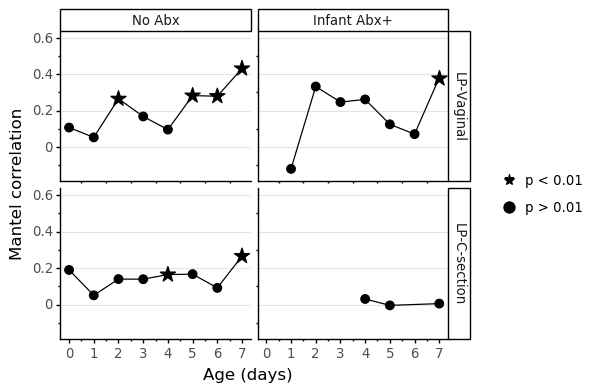

<ggplot: (8745812238870)>

In [36]:
plot_dat = mantel_df.copy()
plot_dat["cohort"] = pd.Categorical(plot_dat.cohort, categories=["LP-Vaginal","LP-C-section"])
plot_dat["abx"] = ["No Abx" if x==0 else "Infant Abx+" for x in plot_dat.abx]
plot_dat["abx"] = pd.Categorical(plot_dat.abx, categories=["No Abx","Infant Abx+"])
pn.options.figure_size= (5,4)

p = (pn.ggplot(data = plot_dat.query('n > 8')) +
     pn.geom_line( pn.aes( x="day", y="cor"), color="black")+
     #pn.geom_text( pn.aes( x="day", y="cor + .1", label="n"), color="black")+
     pn.geom_point( pn.aes( x="day", y="cor", shape="sig", size="sig"), color="black")+
     pn.facet_grid('cohort~abx') +
     pn.scale_shape_manual(['*','o']) +
     pn.scale_size_manual([6,3]) +
     pn.scale_x_continuous(breaks = [0,1,2,3,4,5,6,7]) +
     pn.scale_y_continuous(limits=[-.15,.6]) +
     pn.labs(shape='', y="Mantel correlation", x="Age (days)") +
     pn.theme_classic(base_size=12) +
     pn.guides(size=None, shape = pn.guide_legend(override_aes={"size":4})) +
     pn.theme( panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.6))
     
     
    )
p.save(root_dir + "results/figures/svg/mantel.svg", dpi=300)
p.save(root_dir + "results/figures/mantel.pdf", dpi=300)
p

____

# mmvec

In [6]:
from qiime2.plugins.mmvec.actions import paired_omics
from qiime2.plugins.mmvec.actions import heatmap

In [97]:
mmvec_ba_output = paired_omics(microbes = bac_qza_stool,
            metabolites = met_qza_stool_ba,
            metadata=md_stool_q2)

100%|██████████| 9878/9878 [00:06<00:00, 1431.08it/s]


In [100]:
met_md_ss = met_md.drop(columns=['CAS_Number','INCHI','IonMode','Smiles'])
met_md_ss.index.name="featureid"
ba_bplt = biplot(mmvec_ba_output.conditional_biplot, q2.Metadata(met_md_ss), number_of_features=10)
ba_bplt.visualization.save(root_dir + "/results/figures/mmvec_ba_biplot.qzv")

'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses//results/figures/mmvec_ba_biplot.qzv'

In [101]:
conditionals = mmvec_ba_output.conditionals.view(pd.DataFrame)

In [102]:
conditionals = conditionals.merge(met_md, )

,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Nitrososphaerales;f__Nitrososphaeraceae;g__Candidatus Nitrososphaera,k__Bacteria;__;__;__;__;__,k__Bacteria;p__Acidobacteria;c__Acidobacteria-5;o__;f__;g__,k__Bacteria;p__Acidobacteria;c__Acidobacteria-6;o__iii1-15;f__;g__,k__Bacteria;p__Acidobacteria;c__Acidobacteria-6;o__iii1-15;f__RB40;g__,k__Bacteria;p__Acidobacteria;c__Acidobacteria-6;o__iii1-15;f__mb2424;g__,k__Bacteria;p__Acidobacteria;c__DA052;o__Ellin6513;f__;g__,k__Bacteria;p__Acidobacteria;c__Solibacteres;o__Solibacterales;f__;g__,k__Bacteria;p__Acidobacteria;c__Solibacteres;o__Solibacterales;f__Solibacteraceae;g__Candidatus Solibacter,k__Bacteria;p__Acidobacteria;c__[Chloracidobacteria];o__PK29;f__;g__,...,k__Bacteria;p__Proteobacteria;c__Zetaproteobacteria;o__Mariprofundales;f__Mariprofundaceae;g__,k__Bacteria;p__Tenericutes;c__Mollicutes;o__Mycoplasmatales;f__Mycoplasmataceae;g__Ureaplasma,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__;g__,k__Bacteria;p__Verrucomicrobia;c__[Pedosphaerae];o__[Pedosphaerales];f__Ellin517;g__,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__Candidatus Xiphinematobacter,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__DA101,k__Bacteria;p__Verrucomicrobia;c__[Spartobacteria];o__[Chthoniobacterales];f__[Chthoniobacteraceae];g__OR-59,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus
featureid,,,,,,,,,,,,,,,,,,,,,
480.2699;4.2436,-1.190423,0.502857,0.697961,1.392361,-1.150346,-0.160294,1.001518,0.641046,0.204776,-0.288508,...,-0.106811,0.524498,1.053021,-0.173020,0.434174,0.207956,1.164535,-0.026133,-0.370994,0.526972
357.2805;5.1581,3.311569,0.685559,0.601189,1.108542,2.821183,1.021108,0.780251,2.610273,2.067110,-0.342284,...,2.577060,1.708694,1.845388,2.931175,0.257784,0.132334,1.154463,3.564855,1.716412,0.160969
373.2774;5.2148,1.441423,0.040608,0.249083,-1.075965,0.180273,-0.741593,0.287576,2.361848,1.750291,-1.938774,...,1.736395,0.242579,1.681725,2.030752,-1.055881,0.189960,0.193648,3.429546,1.828036,0.748733
371.2608;4.4252,-0.652967,-1.753128,0.670464,-1.434874,1.331028,-0.149881,-1.407358,0.319277,-0.358109,0.195411,...,-0.137027,-1.686780,-3.949309,-2.448912,0.785343,-1.496870,-0.428999,-3.303357,-2.031762,-3.080551
389.2754;4.5469,3.717300,0.505899,-0.892751,2.908467,3.741601,1.759703,0.218572,0.499021,0.474974,0.433009,...,1.509988,2.388230,1.447436,2.717287,0.217710,-0.995197,0.789473,2.374642,0.242559,-1.147659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355.2623;3.2873,2.993168,-0.542068,2.266754,-0.363036,4.417135,1.176327,0.023653,4.054794,2.666004,0.183021,...,3.241240,0.282974,-1.609216,0.947604,1.625266,-0.548051,1.348641,0.969187,0.549595,-2.104728
414.2991;3.333,-1.364019,-0.787185,-1.846827,0.256245,-1.112902,-0.498386,-1.097918,-2.827028,-2.252518,-0.079575,...,-2.111255,-0.588952,-1.050829,-1.436397,-0.848780,-1.222651,-1.206848,-2.147238,-1.873664,-1.169771
464.2825;2.9949,-0.214897,-0.571332,0.633649,-2.338086,-0.908630,-1.354352,-0.176911,1.940949,1.260268,-1.873742,...,0.932979,-1.039521,0.072277,0.265168,-0.888023,0.145247,-0.247686,1.438960,1.046795,0.347991


Secondary bile acid mmvec

In [108]:
mmvec_sba_output = paired_omics(microbes = bac_qza_stool,
            metabolites = met_qza_stool_sba,
            metadata=md_stool_q2)

100%|██████████| 9872/9872 [00:05<00:00, 1671.69it/s]


In [109]:
met_md_ss = met_md.drop(columns=['CAS_Number','INCHI','IonMode','Smiles'])
met_md_ss.index.name="featureid"
sba_bplt = biplot(mmvec_sba_output.conditional_biplot, q2.Metadata(met_md_ss), number_of_features=10)
sba_bplt.visualization.save(root_dir + "/results/figures/mmvec_sba_biplot.qzv")

'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses//results/figures/mmvec_sba_biplot.qzv'

In [121]:
conditionals = mmvec_sba_output.conditionals.view(pd.DataFrame)
#conditionals = conditionals.merge(met_md, right_index=True, left_index=True)

In [254]:
conditional_ranking =pd.DataFrame( conditionals.transpose()\
    .apply(axis=1, func=lambda x: max(x)) ,columns=["max_conditional"])\
    .sort_values("max_conditional", ascending=False).head(20)
conditional_ranking_mean =pd.DataFrame( conditionals.transpose()\
    .apply(axis=1, func=lambda x: x.mean()) ,columns=["max_conditional"])\
    .sort_values("max_conditional", ascending=False).head(20)

n=20
microbe_list =conditional_ranking.index[:n]
microbe_list = conditional_ranking_mean.index[:n]

In [255]:
plot_dat = conditionals.reset_index().melt(id_vars="featureid")\
    .merge(met_md, right_index=True, left_on="featureid")
plot_dat["short_met_name"] = [x[-20:] for x in plot_dat.Annotation]
plot_dat["short_met_name2"] = plot_dat.apply(axis=1, func= lambda row: str(row.featureid) + row.short_met_name )
plot_dat["short_microbe_name"] = [';'.join(x.split(';')[-4:]) for x in plot_dat.variable]

plot_dat = plot_dat.query('variable in @microbe_list')

In [256]:
plot_dat.head()

,featureid,variable,value,Adduct,Annotation,Bile_Acid_Class,Bile_Acid_Subclass,CAS_Number,Compound_Name,Compound_Source,...,Smiles,StandardMatch,Structural_Classification,Structural_Identification,row_m_z,row_retention_time,Bile_acid_full_class,short_met_name,short_met_name2,short_microbe_name
208,371.2608;4.4252,k__Bacteria;p__Acidobacteria;c__Solibacteres;o...,-1.277548,nan,"(R)-4-((3R,5S,8R,9S,10S,13R,14S,17R)-3-hydroxy...",Secondary,Not Conjugated,nan,nan,nan,...,nan,No,Secondary,Oxidation,371.26075430000003,4.425223016,SecondaryNot Conjugated,yl)pent-2-enoic acid,371.2608;4.4252yl)pent-2-enoic acid,c__Solibacteres;o__Solibacterales;f__Solibacte...
364,371.2608;4.4252,k__Bacteria;p__Actinobacteria;c__Acidimicrobii...,0.952377,nan,"(R)-4-((3R,5S,8R,9S,10S,13R,14S,17R)-3-hydroxy...",Secondary,Not Conjugated,nan,nan,nan,...,nan,No,Secondary,Oxidation,371.26075430000003,4.425223016,SecondaryNot Conjugated,yl)pent-2-enoic acid,371.2608;4.4252yl)pent-2-enoic acid,c__Acidimicrobiia;o__Acidimicrobiales;f__C111;g__
494,371.2608;4.4252,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,-2.389747,nan,"(R)-4-((3R,5S,8R,9S,10S,13R,14S,17R)-3-hydroxy...",Secondary,Not Conjugated,nan,nan,nan,...,nan,No,Secondary,Oxidation,371.26075430000003,4.425223016,SecondaryNot Conjugated,yl)pent-2-enoic acid,371.2608;4.4252yl)pent-2-enoic acid,c__Actinobacteria;o__Actinomycetales;f__Crypto...
572,371.2608;4.4252,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,1.466892,nan,"(R)-4-((3R,5S,8R,9S,10S,13R,14S,17R)-3-hydroxy...",Secondary,Not Conjugated,nan,nan,nan,...,nan,No,Secondary,Oxidation,371.26075430000003,4.425223016,SecondaryNot Conjugated,yl)pent-2-enoic acid,371.2608;4.4252yl)pent-2-enoic acid,c__Actinobacteria;o__Actinomycetales;f__Microc...
676,371.2608;4.4252,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,-0.900816,nan,"(R)-4-((3R,5S,8R,9S,10S,13R,14S,17R)-3-hydroxy...",Secondary,Not Conjugated,nan,nan,nan,...,nan,No,Secondary,Oxidation,371.26075430000003,4.425223016,SecondaryNot Conjugated,yl)pent-2-enoic acid,371.2608;4.4252yl)pent-2-enoic acid,c__Actinobacteria;o__Actinomycetales;f__Microm...


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
  PlotnineWarning)


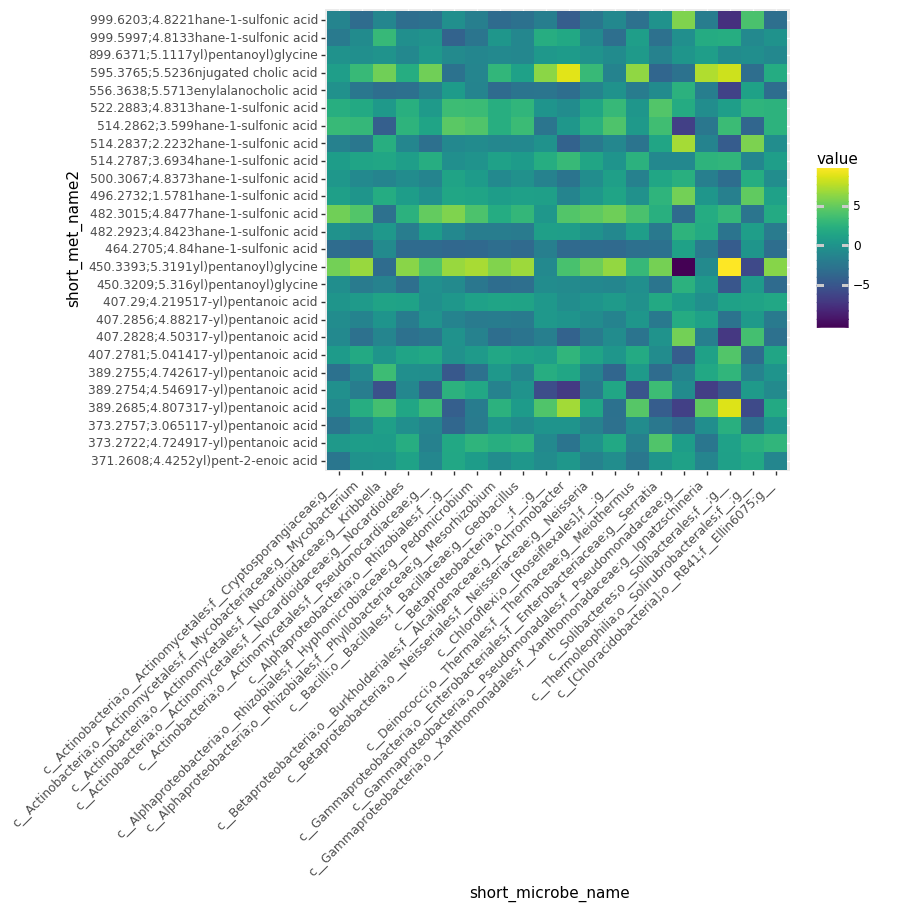

<ggplot: (8763414631884)>

In [169]:
pn.options.figure_size = (6,6) 
p = ( pn.ggplot(data = plot_dat) +
     pn.geom_tile( pn.aes(x="short_microbe_name", y="short_met_name2", fill="value")) +
     pn.theme( axis_text_x = pn.element_text(angle=45, hjust=1)) +
     pn.scale_color_brewer(palette=2)
    )

p

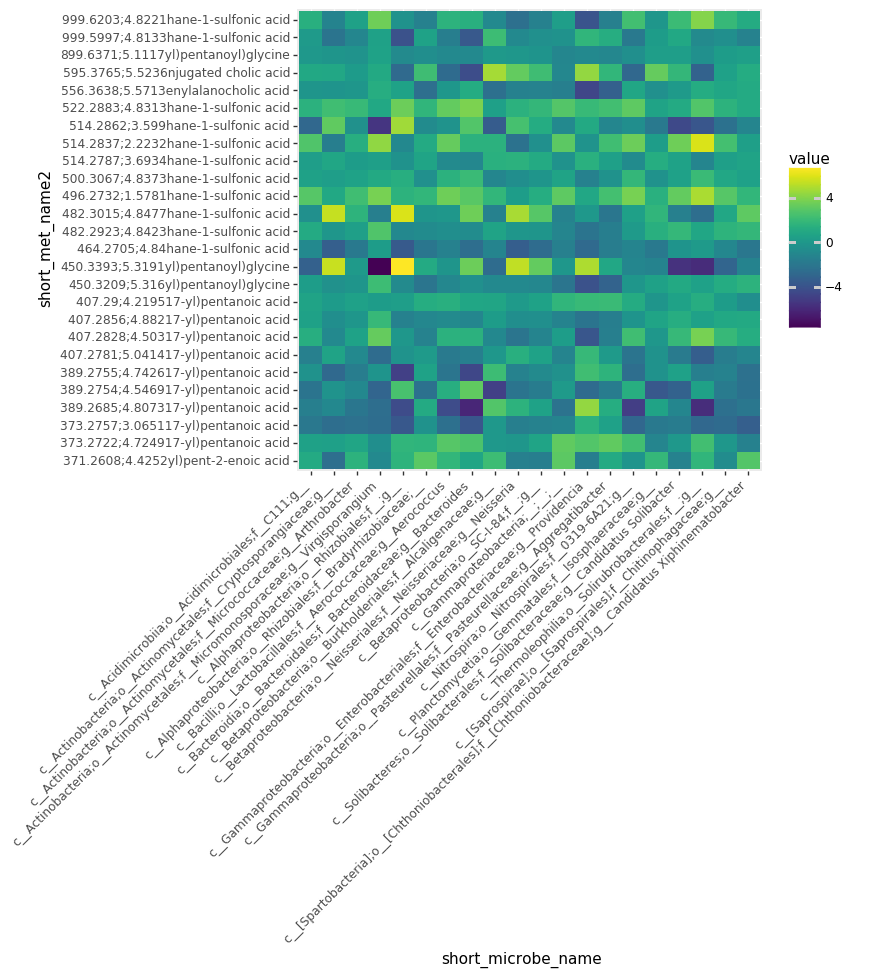

<ggplot: (-9223363273442362322)>

In [274]:
pn.options.figure_size = (6,6) 
p = ( pn.ggplot(data = plot_dat) +
     pn.geom_tile( pn.aes(x="short_microbe_name", y="short_met_name2", fill="value")) +
     pn.theme( axis_text_x = pn.element_text(angle=45, hjust=1))
     #pn.scale_fill_distiller(palette = 1)
    )

p

In [302]:
#tax_qza =  q2.Artifact.load(root_dir + "intermediate_data/stody_seq_classification.qza")
#tax_md_qza = q2.Metadata(pd.DataFrame(tax_qza.view(pd.Series)))

tax_df = pd.DataFrame(index=bac_bt_filt.ids("observation"), data=bac_bt_filt.ids("observation"), columns=["Taxon"])
tax_df.index.name = "featureid"
tax_md_qza = q2.Metadata(tax_df)

In [286]:
met_md_ss = met_md.drop(columns=['CAS_Number','INCHI','IonMode','Smiles'])
met_md_qza = q2.Metadata(met_md_ss)

In [288]:
met_md_ss.Bile_Acid_Subclass.

,Adduct,Annotation,Bile_Acid_Class,Bile_Acid_Subclass,Compound_Name,Compound_Source,LibMZ,LibraryQualityString,StandardMatch,Structural_Classification,Structural_Identification,row_m_z,row_retention_time,Bile_acid_full_class
featureid,,,,,,,,,,,,,,
365.1063;0.2553,[M+Na]+,nan,nan,nan,Melibiose,isolated,365.105,Bronze,nan,nan,nan,nan,nan,nannan
158.1547;4.8705,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
192.979;12.3976,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
242.2907;6.9078,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
339.3473;9.2091,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282.1737;2.0703,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
497.0807;0.235,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
188.1644;1.3869,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan


In [291]:
met_md_ss.Bile_Acid_Subclass.value_counts()

nan               23933
Conjugated           92
Not Conjugated       34
Name: Bile_Acid_Subclass, dtype: int64

In [335]:
met_md_ss.query('Bile_Acid_Class=="Secondary" & StandardMatch!="No"').shape

(13, 14)

In [336]:
met_md_ss.query('Bile_Acid_Class=="Secondary"').shape

(26, 14)

In [339]:
met_md_ss.query('Bile_Acid_Class=="Secondary" & StandardMatch not in ["No","nan"]')

,Adduct,Annotation,Bile_Acid_Class,Bile_Acid_Subclass,Compound_Name,Compound_Source,LibMZ,LibraryQualityString,StandardMatch,Structural_Classification,Structural_Identification,row_m_z,row_retention_time,Bile_acid_full_class
featureid,,,,,,,,,,,,,,
450.3209;5.316,M+H,"((4R)-4-((3R,5R,9S,10S,12R,13R,14S,17R)-3,12-d...",Secondary,Conjugated,GLYCOCHENODEOXYCHOLIC ACID,Commercial,450.32199999999995,Bronze,Glycodeoxycholic acid,Primary Conjugated,"2 Hydroxyls, Glycine Conjugated",450.320858,5.315962708,SecondaryConjugated
500.3067;4.8373,M+H,"2-((R)-4-((3R,5S,7S,8R,9S,10S,13R,14S,17R)-3,7...",Secondary,Conjugated,Spectral Match to Tauroursodeoxycholic acid fr...,Isolated,500.30400000000003,Bronze,"Taurodeoxycholic acid, Secondary Conjugated",Secondary Conjugated,"2 Hydroxyls, Taurine Conjugation",500.3066555,4.837279103,SecondaryConjugated
482.3015;4.8477,M+H-H2O,"2-((4R)-4-((3R,5S,7R,9S,10S,13R,14S,17R)-3,7-d...",Secondary,Conjugated,Tauroursodeoxycholic acid,Isolated,482.293,Bronze,"Taurodeoxycholic acid, Secondary Conjugated",Secondary Conjugated,"2 Hydroxyls, Taurine Conjugation",482.3014829,4.847719393999999,SecondaryConjugated
522.2883;4.8313,M+Na,"2-((4R)-4-((5S,9S,10S,12R,13R,14S,17R)-12-hydr...",Secondary,Conjugated,Spectral Match to Tauroursodeoxycholic acid fr...,Isolated,522.286,Bronze,"Taurodeoxycholic acid, Secondary Conjugated",Secondary Conjugated,"2 Hydroxyls, Taurine Conjugation",522.2882814,4.831343229,SecondaryConjugated
482.2923;4.8423,M+H-H2O,"2-((R)-4-((3R,5S,7S,8R,9S,10S,13R,14S,17R)-3,7...",Secondary,Conjugated,Tauroursodeoxycholic acid,Isolated,482.293,Bronze,"Taurodeoxycholic acid, Secondary Conjugated",Secondary Conjugated,"2 Hydroxyls, Taurine Conjugation",482.2922799,4.8423128019999995,SecondaryConjugated
999.6203;4.8221,nan,"2-((R)-4-((3R,5S,7S,8R,9S,10S,13R,14S,17R)-3,7...",Secondary,Conjugated,nan,nan,nan,nan,"Taurodeoxycholic acid, Secondary Conjugated",Secondary Conjugated,"2 Hydroxyls, Taurine Conjugation",999.6203482000001,4.8220904760000005,SecondaryConjugated
464.2705;4.84,M+H-2H2O,"2-((4R)-4-((3R,5R,6S,9S,10R,13R,14S,17R)-3,6-d...",Secondary,Conjugated,Tauroursodeoxycholic acid,Isolated,464.283,Bronze,"Taurodeoxycholic acid, Secondary Conjugated",Secondary Conjugated,"2 Hydroxyls, Taurine Conjugation",464.2704976,4.840044444,SecondaryConjugated
899.6371;5.1117,nan,"((4R)-4-((3R,5R,9S,10S,12R,13R,14S,17R)-3,12-d...",Secondary,Conjugated,nan,nan,nan,nan,Glycodeoxycholic acid,Primary Conjugated,"2 Hydroxyls, Glycine Conjugation",899.6370926000001,5.111735417,SecondaryConjugated
999.5997;4.8133,nan,"2-((R)-4-((3R,5S,7S,8R,9S,10S,13R,14S,17R)-3,7...",Secondary,Conjugated,nan,nan,nan,nan,"Taurodeoxycholic acid, Secondary Conjugated",Secondary Conjugated,"2 Hydroxyls, Taurine Conjugation",999.5996617000001,4.8132809519999995,SecondaryConjugated


In [330]:
met_md_ss.query('Bile_Acid_Class=="Secondary"').iloc[1,1]

'(4R)-4-((2S,3S,5R,7R,9S,10S,12S,13R,14S,17R)-2,3,7,12-tetrahydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid'

In [322]:
lev_4_heatmap.visualization.save("fig.qzv")

'fig.qzv'

In [312]:
lev_4_heatmap..save("heatmap_test")

AttributeError: 'Results' object has no attribute 'Visualization'

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/mmvec/heatmap.py:314: UserWarning: Conditional probabilities table and microbe metadata will be filtered to contain only the intersection of IDs in each. If this behavior is undesired, ensure that all microbe IDs are present in both the table and the metadata file
  warnings.warn(warning, UserWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/mmvec/heatmap.py:314: UserWarning: Conditional probabilities table and metabolite metadata will be filtered to contain only the intersection of IDs in each. If this behavior is undesired, ensure that all metabolite IDs are present in both the table and the metadata file
  warnings.warn(warning, UserWarning)


<Figure size 720x720 with 0 Axes>

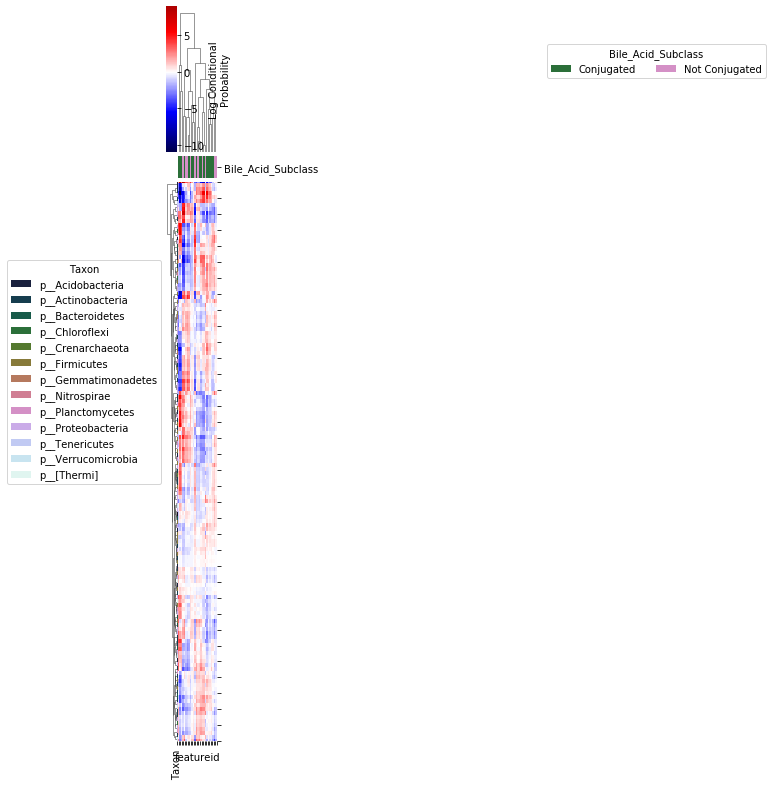

In [315]:
plt.figure(figsize=(10,10)) 

lev_4_heatmap = heatmap(ranks = mmvec_sba_output.conditionals,
       microbe_metadata = tax_md_qza.get_column("Taxon"),
       metabolite_metadata=met_md_qza.get_column("Bile_Acid_Subclass"), level=2)

In [311]:
type(lev_4_heatmap)

qiime2.sdk.results.Results

In [276]:
?heatmap

In [ ]:
qiime mmvec heatmap \
  --i-ranks ranks.qza \
  --m-microbe-metadata-file taxonomy.tsv \
  --m-microbe-metadata-column Taxon \
  --m-metabolite-metadata-file metabolite-metadata.txt \
  --m-metabolite-metadata-column Compound_Source \
  --p-level 5 \
  --o-visualization ranks-heatmap.qzv

# MMvec with confirmed secondary bile acids (collapsed to just 2)

In [361]:
met_md.

,Adduct,Annotation,Bile_Acid_Class,Bile_Acid_Subclass,CAS_Number,Compound_Name,Compound_Source,INCHI,IonMode,LibMZ,LibraryQualityString,Smiles,StandardMatch,Structural_Classification,Structural_Identification,row_m_z,row_retention_time,Bile_acid_full_class
featureid,,,,,,,,,,,,,,,,,,
365.1063;0.2553,[M+Na]+,nan,nan,nan,nan,Melibiose,isolated,InChI=1S/C12H22O11/c13-1-3-5(14)8(17)10(19)12(...,positive,365.105,Bronze,nan,nan,nan,nan,nan,nan,nannan
158.1547;4.8705,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
192.979;12.3976,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
242.2907;6.9078,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
339.3473;9.2091,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282.1737;2.0703,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
497.0807;0.235,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan
188.1644;1.3869,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nannan


In [360]:
met_bt_stool_csba_collapse.sum("observation")

array([ 66865.9662073 , 259771.27277988])

In [370]:
#Make met metadata
csba_met_md = met_md_ss.query('Bile_Acid_Class=="Secondary" & StandardMatch not in ["No","nan"]').iloc[0:2,:].set_index("StandardMatch")
csba_met_md.index.name="featureid"
csba_met_md_qza = q2.Metadata(csba_met_md)


mmvec_csba_output = paired_omics(microbes = bac_qza_stool,
            metabolites = met_qza_stool_csba,
            metadata=csba_met_md_qza)

100%|██████████| 9950/9950 [00:05<00:00, 1744.43it/s]


ValueError: k must be between 1 and min(A.shape), k=3

In [86]:
mmvec_output = paired_omics(microbes = bac_qza_stool_filt,
            metabolites = met_qza_stool_filt,
            metadata=md_stool_q2)

100%|██████████| 1726/1726 [00:33<00:00, 50.86it/s]


In [50]:
from qiime2.plugins.emperor.actions import biplot

In [51]:
mmvec_output

Results (name = value)
--------------------------------------------------------------------------------------------------------------
conditionals       = <artifact: FeatureData[Conditional] uuid: 5527d442-70ef-4455-a9db-24b54c9ef503>
conditional_biplot = <artifact: PCoAResults % Properties('biplot') uuid: 501b90d7-0af1-4f7c-a093-ba564d7efbda>

In [62]:
bplt = biplot(mmvec_output.conditional_biplot, q2.Metadata(met_md_ss))

In [66]:
?biplot

In [64]:
bplt

Results (name = value)
-----------------------------------------------------------------------------------------
visualization = <visualization: Visualization uuid: 161a04e9-6319-4f5c-b001-e192ac9a551f>

In [65]:
bplt.visualization.save(root_dir + "/results/figures/mmvec_biplot.qzv")

'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses//results/figures/mmvec_biplot.qzv'

In [9]:
conditionals = mmvec_output.conditionals.view(pd.DataFrame)

In [10]:
conditionals_ba.apply(axis=0, func="mean").sort_values(ascending=False)[:n]

NameError: name 'conditionals_ba' is not defined

In [223]:
conditionals_ba.apply(axis=0, func="mean").sort_values(ascending=False)[-(n+1):-1]

k__Bacteria;p__Tenericutes;c__Mollicutes;o__Mycoplasmatales;f__Mycoplasmataceae;g__Ureaplasma                -0.004455
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides                -0.037381
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas   -0.038123
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria            -0.053745
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus                 -0.057473
dtype: float64

In [49]:
bile_acid_list = set(met_md.query('Bile_Acid_Class != "nan"').index)
secondary_bile_acid_list = set(met_md.query('Bile_Acid_Class == "Secondary"').index)
conditionals_ba = conditionals.query('index in @bile_acid_list')


n=20
positive_bacteria = conditionals_ba.apply(axis=0, func="mean").sort_values(ascending=False)[:n].index
negative_bacteria = conditionals_ba.apply(axis=0, func="mean").sort_values(ascending=False)[-(n+1):-1].index

temp_list = list(positive_bacteria) +  list(negative_bacteria)
top_conditionalsa_ba = conditionals_ba.loc[:,temp_list].reset_index().melt(id_vars="featureid")

top_conditionalsa_ba["variable"] = pd.Categorical(top_conditionalsa_ba["variable"], categories=temp_list)

top_conditionalsa_ba = top_conditionalsa_ba.merge(met_md, right_index=True, left_on="featureid")

ValueError: Categorical categories must be unique

In [35]:

top_conditionalsa_ba["full_class"] = top_conditionalsa_ba.apply(axis=1, func=lambda row: row.Bile_Acid_Class + row.Bile_Acid_Subclass)

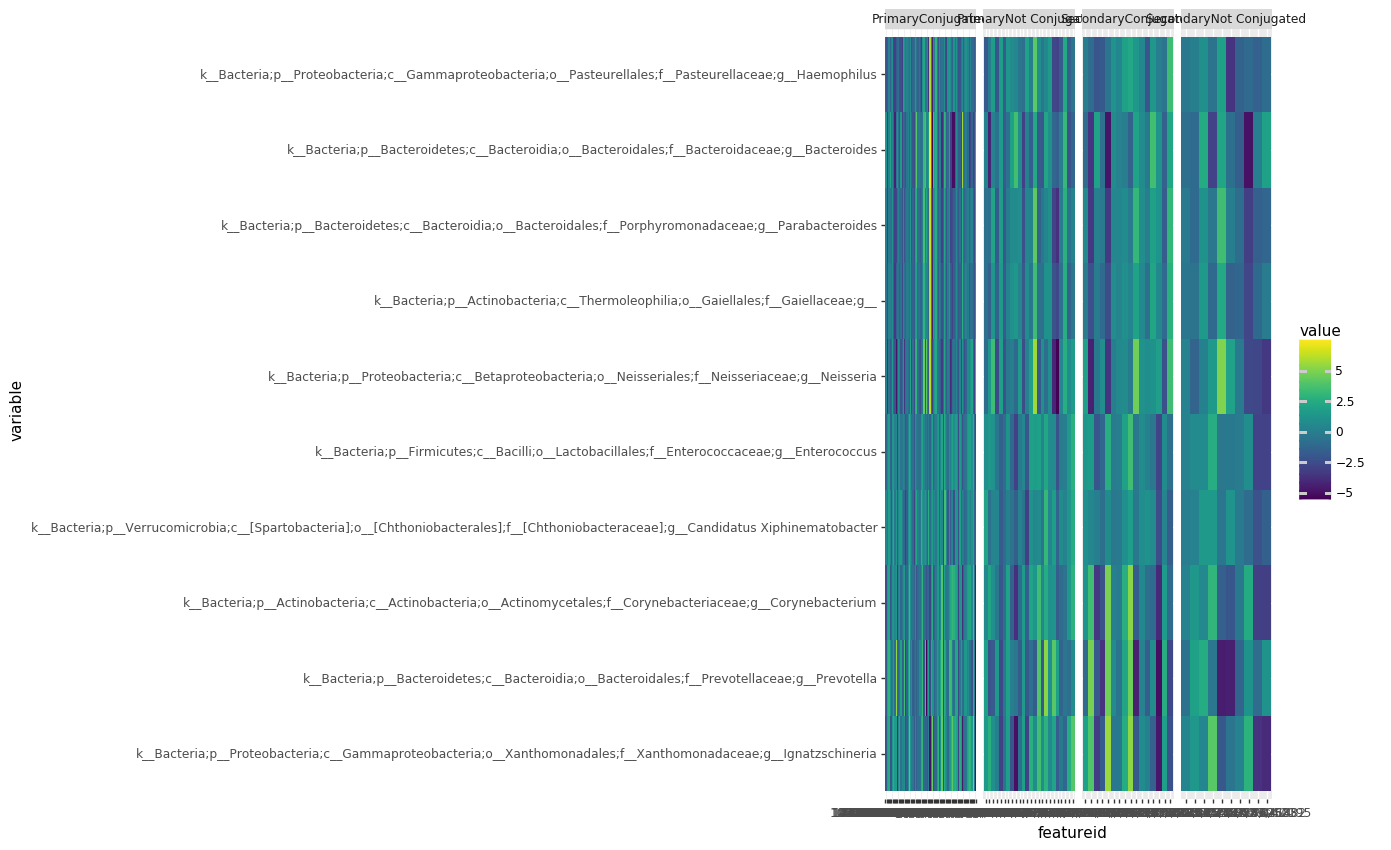

<ggplot: (8763412922937)>

In [39]:
pn.options.figure_size = (5, 10)

p = (pn.ggplot( data=top_conditionalsa_ba) +
    pn.geom_tile(pn.aes (y="variable", x="featureid", fill="value")) +
     pn.facet_grid('.~full_class', margins="free", scales="free")

)
p

In [240]:
bac_df = pd.DataFrame(bac_bt_stool_filt.to_dataframe())
sample_order=bac_df.columns
met_df = pd.DataFrame(met_bt_stool_filt.to_dataframe()).loc[:,sample_order]

assert(all([x==y for x,y in zip(bac_df.columns, met_df.columns)]))



In [226]:
out_list = []

for bac in positive_bacteria:
    x=bac_df.loc[bac]
    y=met_df.query('index in @secondary_bile_acid_list').sum(axis=0)
    for subject,dat in x.items():
        out_list.append([bac, i, x[subject], y[subject]])
positive_df = pd.DataFrame(out_list, columns=["bacteria", "host_subject_id","microbe_abundance", "ba_abundance"])    

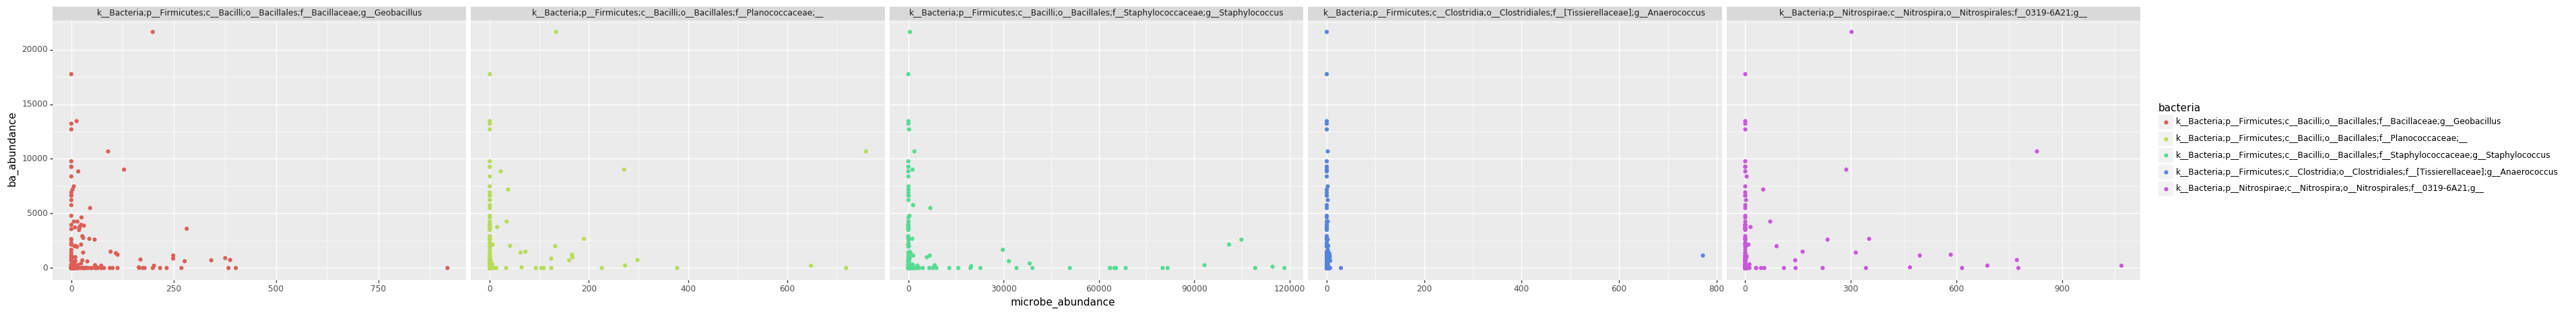

<ggplot: (-9223363297142055301)>

In [227]:
pn.options.figure_size = (40,5)
p = (pn.ggplot(data = positive_df) +
    pn.geom_point( pn.aes( x="microbe_abundance", y="ba_abundance", color="bacteria")) +
     pn.facet_grid('.~bacteria', space="free", scales="free")
    
    
    )
p

In [229]:
out_list = []

for bac in negative_bacteria:
    x=bac_df.loc[bac]
    y=met_df.query('index in @secondary_bile_acid_list').sum(axis=0)
    for subject,dat in x.items():
        out_list.append([bac, i, x[subject], y[subject]])
negative_df = pd.DataFrame(out_list, columns=["bacteria", "host_subject_id","microbe_abundance", "ba_abundance"])    

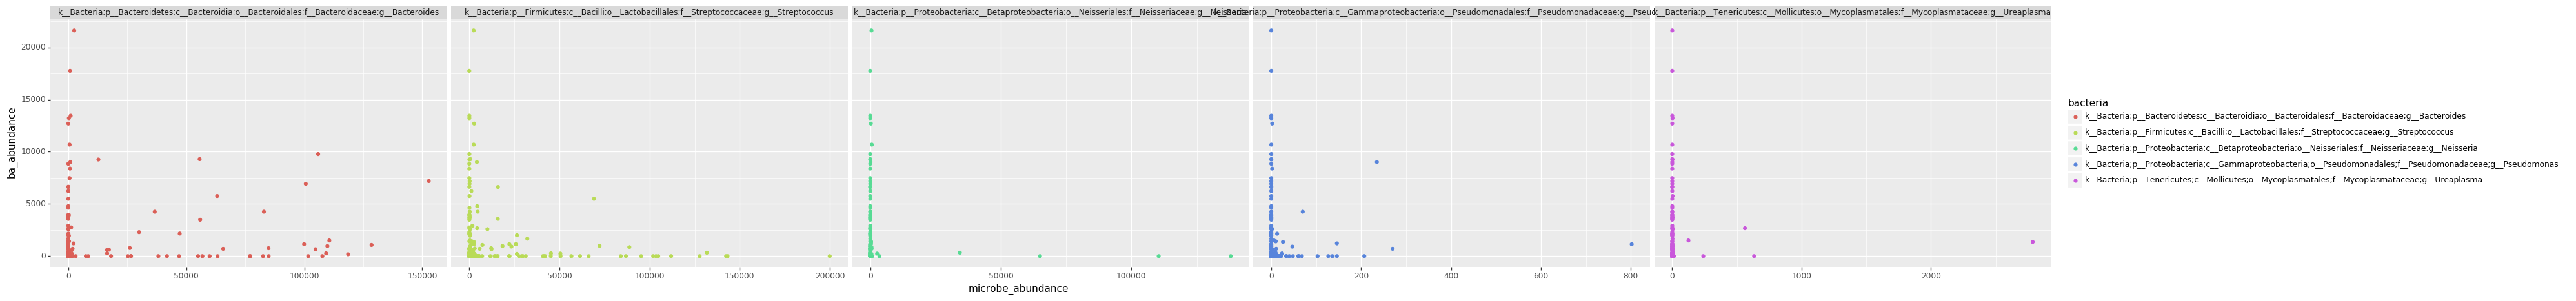

<ggplot: (-9223363297136054798)>

In [230]:
pn.options.figure_size = (40,5)
p = (pn.ggplot(data = negative_df) +
    pn.geom_point( pn.aes( x="microbe_abundance", y="ba_abundance", color="bacteria")) +
     pn.facet_grid('.~bacteria', space="free", scales="free")
    
    
    )
p

In [241]:
fa_list = ["docosahexanoic",
"arachidonic",
"linoleic",
"oleic",
"palmitic"]
fatty_acid_namess= [x for x in met_md.Compound_Name if any([y in x.lower() for y in fa_list])]
fatty_acid_ids = set(met_md.query('Compound_Name in @fatty_acid_namess').index)

In [242]:

conditionals_fa = conditionals.query('index in @fatty_acid_ids')


n=5
positive_bacteria = conditionals_fa.apply(axis=0, func="mean").sort_values(ascending=False)[:n].index
negative_bacteria = conditionals_fa.apply(axis=0, func="mean").sort_values(ascending=False)[-(n+1):-1].index

temp_list = list(positive_bacteria) +  list(negative_bacteria)
top_conditionals_fa = conditionals_fa.loc[:,temp_list].reset_index().melt(id_vars="featureid")

top_conditionals_fa["variable"] = pd.Categorical(top_conditionals_fa["variable"], categories=temp_list)


In [245]:
out_list = []

for bac in positive_bacteria:
    x=bac_df.loc[bac]
    y=met_df.query('index in @fatty_acid_ids').sum(axis=0)
    for subject,dat in x.items():
        out_list.append([bac, i, x[subject], y[subject]])
positive_df = pd.DataFrame(out_list, columns=["bacteria", "host_subject_id","microbe_abundance", "fa_abundance"])    

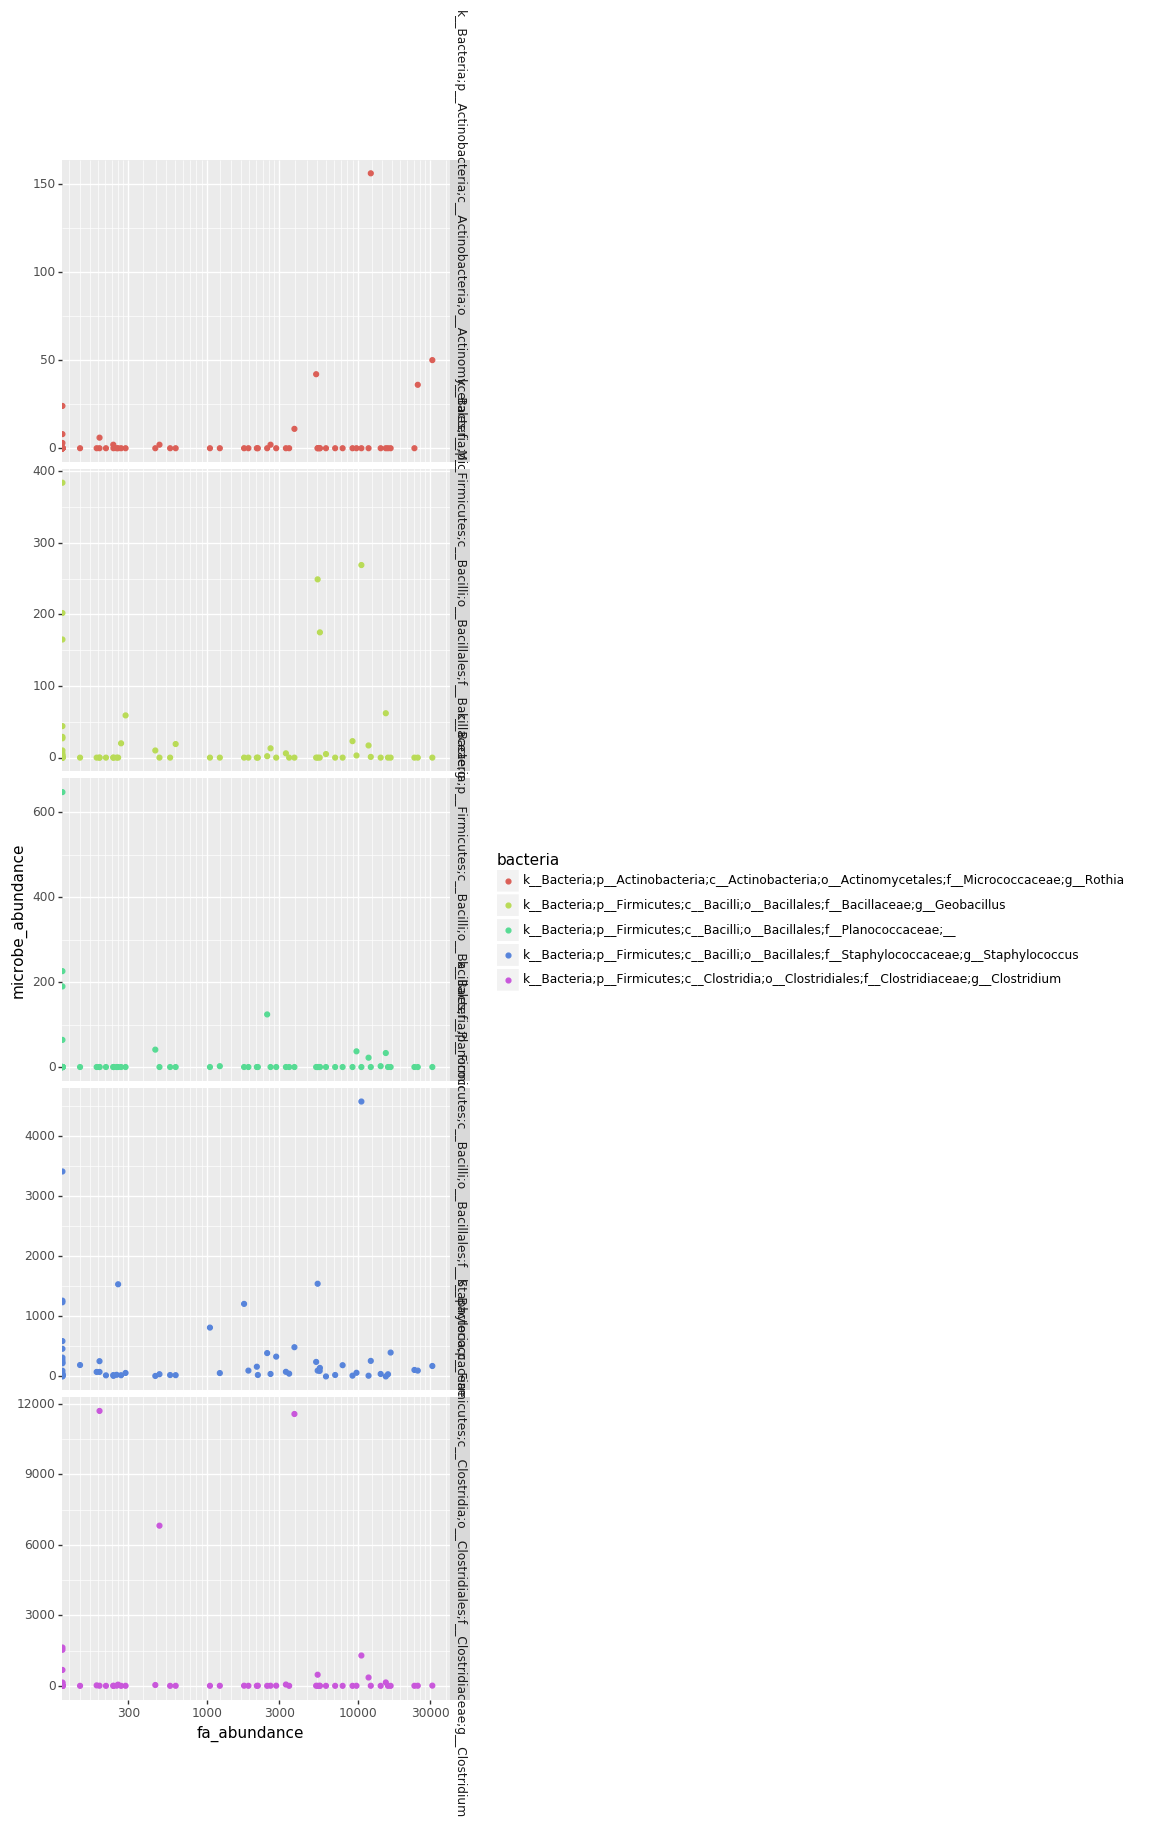

<ggplot: (-9223363297135856135)>

In [248]:
pn.options.figure_size = (5,20)
p = (pn.ggplot(data = positive_df) +
    pn.geom_point( pn.aes( y="microbe_abundance", x="fa_abundance", color="bacteria")) +
     pn.facet_grid('bacteria~.', space="free", scales="free") +
     pn.scale_x_log10()
    
    
    )
p

# Correlations to 2/1 log ratio

In [176]:
bile_acid_export = pd.read_csv("../bile_acid_export.tsv", sep='\t', index_col=0)\
    .merge(md, right_index=True, left_index=True)
bile_acid_export = bile_acid_export.loc[bile_acid_export.Current_Natural_Log_Ratio.notna()]

In [193]:
log_ratios = bile_acid_export.loc[:,["Current_Natural_Log_Ratio"]]
log_samples = set(log_ratios.index)
bac_samples = set(bac_bt_stool.ids())
samples_keep = log_samples & bac_samples

bac_df_stool_filt = bac_bt_stool.filter(samples_keep, inplace=False).to_dataframe().loc[:,samples_keep]
log_ratios = log_ratios.query('index in @samples_keep').loc[samples_keep]

#Ensure same order
assert [x==y for x,y in zip(bac_df_stool_filt.columns, log_ratios.index)], "Wrong order"

In [197]:
import scipy.stats

In [247]:
out_list = []
lr = log_ratios.Current_Natural_Log_Ratio

microbes = set(bac_df_stool_filt.index)
for bac in microbes:
    abundances = bac_df_stool_filt.loc[bac].values
    nonzero = abundances > 0
    abundances = abundances[nonzero]
    lr_nonzero = lr[nonzero]
    if sum(nonzero) < 10:
        continue
    corr = scipy.stats.spearmanr(abundances, lr_nonzero)
    if corr.correlation == corr.correlation:
        result = [bac,corr.correlation , corr.pvalue]
        out_list.append(result)

corr_df = pd.DataFrame(out_list, columns=["microbe","spearman","p"])

In [252]:
corr_df.query('p < .05 & spearman > 0').sort_values("spearman", ascending=False).microbe.values

array(['k__Bacteria;p__Firmicutes;c__Bacilli;__;__;__'], dtype=object)

In [241]:
abundances

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fill: 0
IntIndex
Indices: array([], dtype=int32)

In [235]:
lr

11712.SUBJECT26.STOOL.569   -2.010325
11712.SUBJECT23.STOOL.498   -1.107418
11712.SUBJECT24.STOOL.527   -0.611024
11712.SUBJECT41.STOOL.963   -0.605615
11712.SUBJECT34.STOOL.750    0.126369
                               ...   
11712.SUBJECT16.STOOL.194    1.118654
11712.SUBJECT37.STOOL.803   -0.566153
11712.SUBJECT39.STOOL.839   -0.002059
11712.SUBJECT41.STOOL.970   -0.434732
11712.SUBJECT9.STOOL.1208   -1.203103
Name: Current_Natural_Log_Ratio, Length: 96, dtype: float64

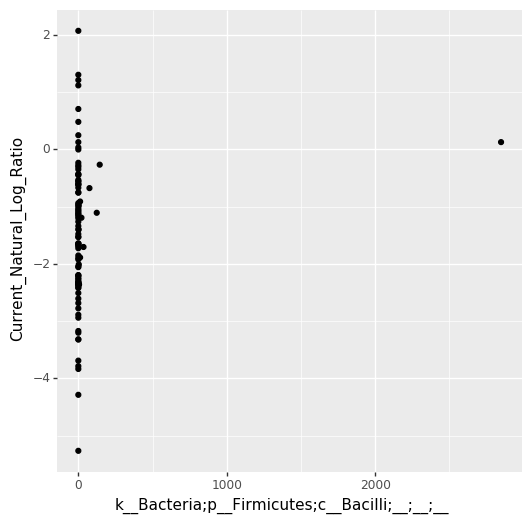

<ggplot: (-9223363273438398471)>

In [253]:
bac = "k__Bacteria;p__Firmicutes;c__Bacilli;__;__;__"
x = bac_df_stool_filt.loc[bac]
y= lr
temp = pd.DataFrame([x,y]).transpose()
temp
p = (pn.ggplot(data = temp) +
    pn.geom_point( pn.aes(x=bac,
                         y="Current_Natural_Log_Ratio"))
    
    )
p